In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [55]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [56]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
inspector = inspect(engine)

In [57]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [58]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [59]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [60]:
#get columns in Measurement
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [61]:
#get columns in Station
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [62]:
#calculate max date in dataset
max_date=session.query(func.max(Measurement.date)).first()
max_date

('2017-08-23')

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


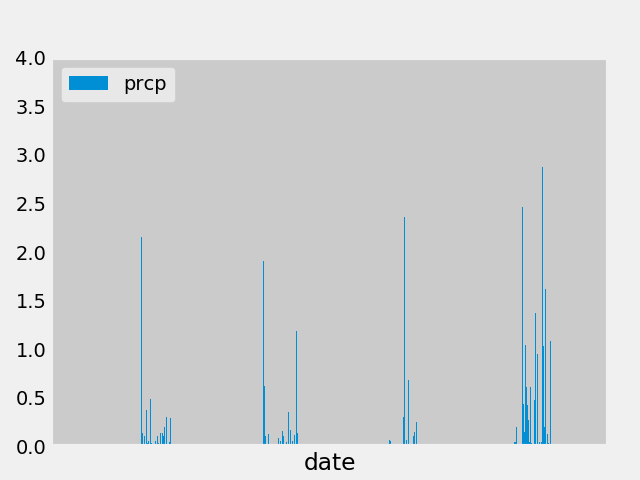

In [144]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from max date in dataset
date_year_ago=dt.date(2017,8,23) - dt.timedelta(days=365)
date_year_ago

# Perform a query to retrieve the data and precipitation scores
prcp_data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>date_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.set_index('date')

# Sort the dataframe by date
prcp_data_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.plot(kind='bar',width=0.3)
plt.ylim(0,4)
plt.xlabel('date')

# Rotate the xticks for the dates
plt.tick_params(labelbottom=False)



In [85]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [88]:
# How many stations are available in this dataset?
session.query(Station.name).distinct().count()

9

In [118]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_activity=session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [119]:
most_active_station=station_activity[0][0]
most_active_station

'USC00519281'

In [91]:
#join Measurements and stations table
sel = [Measurement.id,Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs,Station.name,Station.latitude,Station.longitude,Station.elevation]
joined_table= session.query(*sel).filter(Measurement.station == Station.station).all()


In [120]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station_stats=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).all()
active_station_stats

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


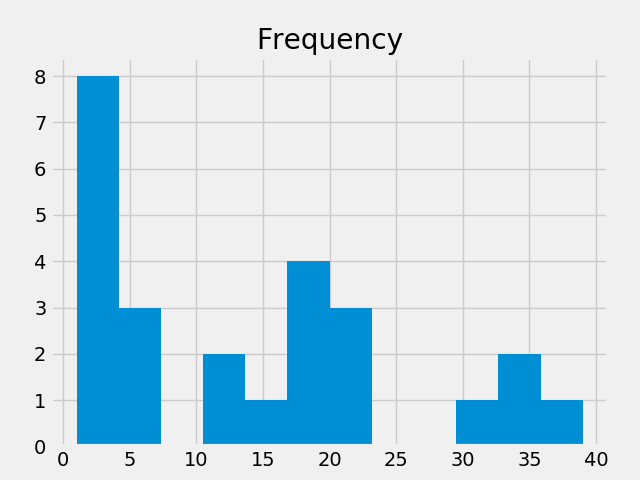

In [143]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs=session.query(Measurement.tobs,func.count(Measurement.tobs)).filter(Measurement.date>date_year_ago).filter(Measurement.station==most_active_station).group_by(Measurement.tobs).all()
tobs_df = pd.DataFrame(tobs,columns=['Tobs', 'Frequency']).set_index('Tobs')
hist = tobs_df.hist(bins=12)
